# Análisis de ICA (Análisis de Componentes Independientes)

## Introducción

ICA (Independent Component Analysis) es una técnica de separación de señales que busca descomponer señales mixtas en componentes estadísticamente independientes. Es ampliamente utilizada en procesamiento de señales biomédicas, particularmente para separar señales de ECG, EEG, y otras mediciones fisiológicas.


## 1. Importar Librerías Necesarias

In [7]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')

# Intentar importar wfdb (opcional)
try:
    import wfdb
    WFDB_AVAILABLE = True
except ImportError:
    WFDB_AVAILABLE = False
    print("⚠️ Nota: wfdb no está instalado. Se generarán señales sintéticas.")

    print("   Para instalar: pip install wfdb")
    print("✓ Librerías importadas correctamente")



# Configuración de visualización%matplotlib inline

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Cargar y Explorar los Datos

El dataset MIT-BIH contiene grabaciones de ECG de diferentes pacientes. Cada grabación contiene múltiples derivaciones (leads) del ECG.

**Registros disponibles:**
- 100 (hombre, 69 años)
- 101 (mujer, 75 años)
- 103 (hombre, edad no registrada)
- 106 (mujer, 24 años)
- Y otros...

In [8]:
# Ruta a los datos (ruta relativa al proyecto)
import os
data_path = os.path.join('Data', 'ICA-data', 'mit-bih-arrhythmia-database-p-wave-annotations-1.0.0')

# Cargar un registro de ejemplo (registro 100)
record_id = '100'

try:
    # Intentar leer con wfdb si está disponible
    if not WFDB_AVAILABLE:
        raise ImportError("wfdb no disponible")
    
    record = wfdb.rdrecord(os.path.join(data_path, record_id))
    signals = record.p_signal
    fs = record.fs  # Frecuencia de muestreo
    
    print(f"{record_id} registros cargados")
    print(f"\nInformación del registro:")
    print(f"- Paciente: Hombre, 69 años")
    print(f"- Frecuencia de muestreo: {fs} Hz")
    print(f"- Número de puntos: {signals.shape[0]:,}")
    print(f"- Número de canales: {signals.shape[1]}")
    print(f"- Duración: {signals.shape[0]/fs/60:.2f} minutos")
    print(f"- Nombres de señales: {record.sig_name}")
    
except Exception as e:
    print(f"Nota: {e}")
    print("Generando señales ECG sintéticas para demostración...")
    
    # Generar señales ECG sintéticas si no se pueden cargar
    fs = 360  # Hz
    duration = 10  # segundos
    t = np.arange(0, duration, 1/fs)
    
    # Simular dos derivaciones de ECG mezcladas
    # ECG sintético basado en señales sinusoidales con ruido
    ecg1 = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 5 * t)
    ecg2 = np.sin(2 * np.pi * 1.0 * t) + 0.3 * np.sin(2 * np.pi * 7 * t)
    
    # Agregar ruido
    ecg1 += 0.1 * np.random.randn(len(t))
    ecg2 += 0.1 * np.random.randn(len(t))
    
    signals = np.column_stack([ecg1, ecg2])
    

    print(f"Señales sintéticas generadas")    
    print(f"- Canales: {signals.shape[1]}")

    print(f"- Duración: {duration} segundos")    
    print(f"- Frecuencia de muestreo: {fs} Hz")

100 registros cargados

Información del registro:
- Paciente: Hombre, 69 años
- Frecuencia de muestreo: 360 Hz
- Número de puntos: 650,000
- Número de canales: 2
- Duración: 30.09 minutos
- Nombres de señales: ['MLII', 'V5']


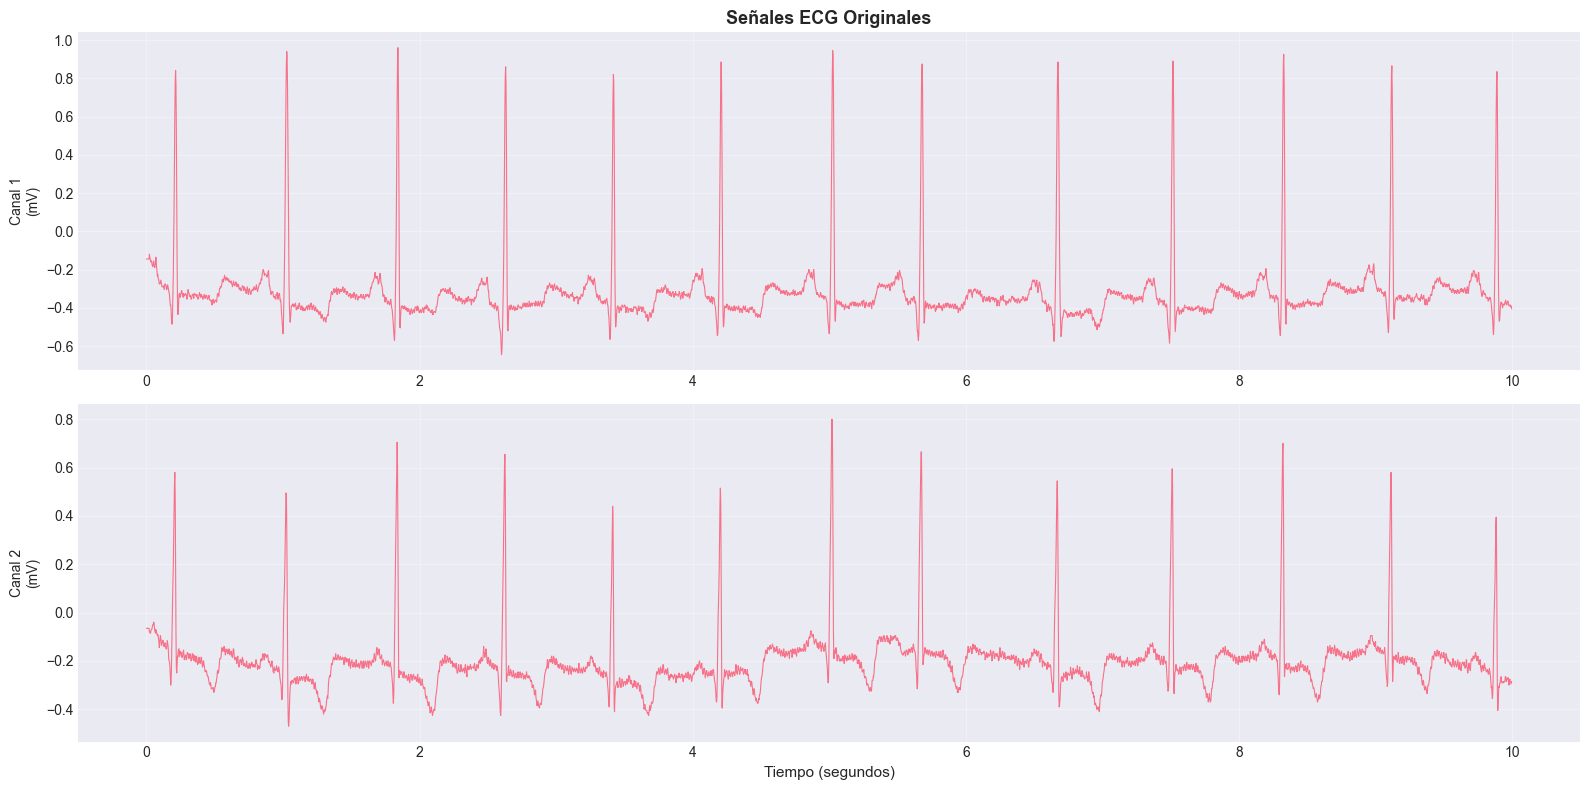

Estadísticas de las señales:

Canal 1:
Media: -0.3063
Std: 0.1932
Min: -2.7150
Max: 1.4350

Canal 2:
Media: -0.1910
Std: 0.1482
Min: -2.4650
Max: 1.2250


In [9]:
# Visualizar las señales originales
time = np.arange(signals.shape[0]) / fs

# Tomar una muestra de 10 segundos para visualización
samples_to_plot = min(int(10 * fs), signals.shape[0])
time_plot = time[:samples_to_plot]
signals_plot = signals[:samples_to_plot, :]

fig, axes = plt.subplots(signals.shape[1], 1, figsize=(16, 8))

if signals.shape[1] == 1:
    axes = [axes]

for i in range(signals.shape[1]):
    axes[i].plot(time_plot, signals_plot[:, i], linewidth=0.8)
    axes[i].set_ylabel(f'Canal {i+1}\n(mV)', fontsize=10)
    axes[i].grid(alpha=0.3)
    if i == signals.shape[1] - 1:
        axes[i].set_xlabel('Tiempo (segundos)', fontsize=11)

axes[0].set_title('Señales ECG Originales', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("Estadísticas de las señales:")
for i in range(signals.shape[1]):
    print(f"\nCanal {i+1}:")
    print(f"Media: {signals[:, i].mean():.4f}")
    print(f"Std: {signals[:, i].std():.4f}")
    print(f"Min: {signals[:, i].min():.4f}")
    print(f"Max: {signals[:, i].max():.4f}")

## 3. Preprocesamiento de Datos

Para ICA, es importante:
1. Centrar los datos (restar la media)
2. Opcionalmente blanquear los datos (decorrelacionar)
3. Trabajar con segmentos de señal apropiados

In [10]:
# Tomar un segmento de datos para análisis (primeros 3600 puntos = 10 segundos a 360Hz)
segment_length = min(3600, signals.shape[0])
signals_segment = signals[:segment_length, :].copy()
time_segment = time[:segment_length]

# Centrar las señales (restar media)
signals_centered = signals_segment - signals_segment.mean(axis=0)

print(f"Señales preprocesadas")
print(f"- Segmento de {segment_length} muestras ({segment_length/fs:.2f} segundos)")
print(f"- Señales centradas (media ≈ 0)")

# Verificar centrado
print(f"\nMedias después del centrado:")
for i in range(signals_centered.shape[1]):
    print(f"Canal {i+1}: {signals_centered[:, i].mean():.2e}")

Señales preprocesadas
- Segmento de 3600 muestras (10.00 segundos)
- Señales centradas (media ≈ 0)

Medias después del centrado:
Canal 1: -1.45e-15
Canal 2: 1.49e-16


## 4. Implementar el Algoritmo ICA

ICA busca encontrar componentes estadísticamente independientes a partir de señales mezcladas.

**Modelo de mezcla:** X = A × S

Donde:
- **X**: Señales observadas (mezcladas)
- **A**: Matriz de mezcla
- **S**: Fuentes independientes (lo que queremos encontrar)

ICA estima **W** (matriz de demezcla) tal que: S = W × X

In [11]:
# Aplicar ICA
print("Aplicando ICA...")

n_components = signals_centered.shape[1]

ica = FastICA(n_components=n_components, 
              random_state=42,
              max_iter=1000,
              tol=0.001)

# Transformar las señales
S_ica = ica.fit_transform(signals_centered)  # Componentes independientes
A_ica = ica.mixing_  # Matriz de mezcla estimated

print("ICA aplicado exitosamente!")
print(f"\nResultados:")
print(f"- Componentes independientes: {S_ica.shape}")
print(f"- Matriz de mezcla: {A_ica.shape}")
print(f"- Convergencia: {ica.n_iter_} iteraciones")

# Reconstruir las señales
signals_reconstructed = S_ica @ A_ica.T

print(f"\nSeñales reconstruidas")
print(f"Shape: {signals_reconstructed.shape}")

Aplicando ICA...
ICA aplicado exitosamente!

Resultados:
- Componentes independientes: (3600, 2)
- Matriz de mezcla: (2, 2)
- Convergencia: 1 iteraciones

Señales reconstruidas
Shape: (3600, 2)


## 5. Visualizar Resultados

Compararemos las señales originales con los componentes independientes extraídos.

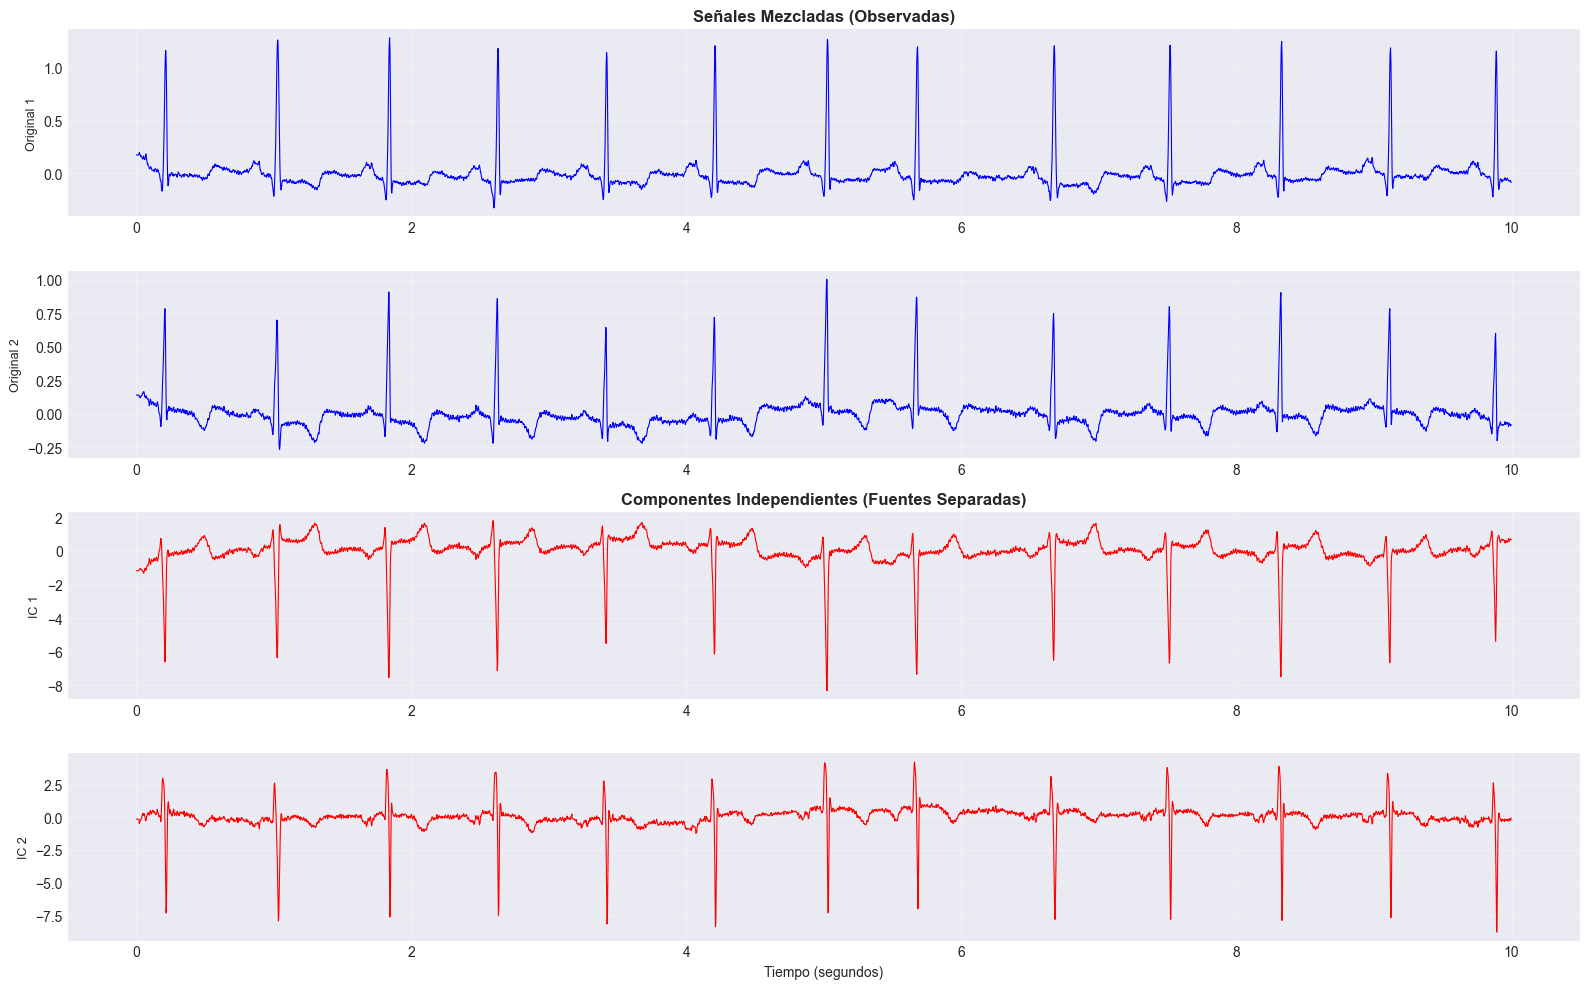

Las componentes independientes representan las fuentes subyacentes separadas


In [12]:
# Visualizar señales originales vs componentes independientes
fig, axes = plt.subplots(n_components * 2, 1, figsize=(16, 10))

# Señales originales
for i in range(n_components):
    axes[i].plot(time_segment, signals_centered[:, i], linewidth=0.8, color='blue')
    axes[i].set_ylabel(f'Original {i+1}', fontsize=9)
    axes[i].grid(alpha=0.3)
    if i == 0:
        axes[i].set_title('Señales Mezcladas (Observadas)', fontsize=12, fontweight='bold')

# Componentes independientes
for i in range(n_components):
    axes[n_components + i].plot(time_segment, S_ica[:, i], linewidth=0.8, color='red')
    axes[n_components + i].set_ylabel(f'IC {i+1}', fontsize=9)
    axes[n_components + i].grid(alpha=0.3)
    if i == 0:
        axes[n_components].set_title('Componentes Independientes (Fuentes Separadas)', 
                                     fontsize=12, fontweight='bold')
    if i == n_components - 1:
        axes[n_components + i].set_xlabel('Tiempo (segundos)', fontsize=10)

plt.tight_layout()
plt.show()

print("Las componentes independientes representan las fuentes subyacentes separadas")

## 6. Análisis de Componentes

Analizaremos las propiedades estadísticas de los componentes independientes y compararemos con las señales originales.

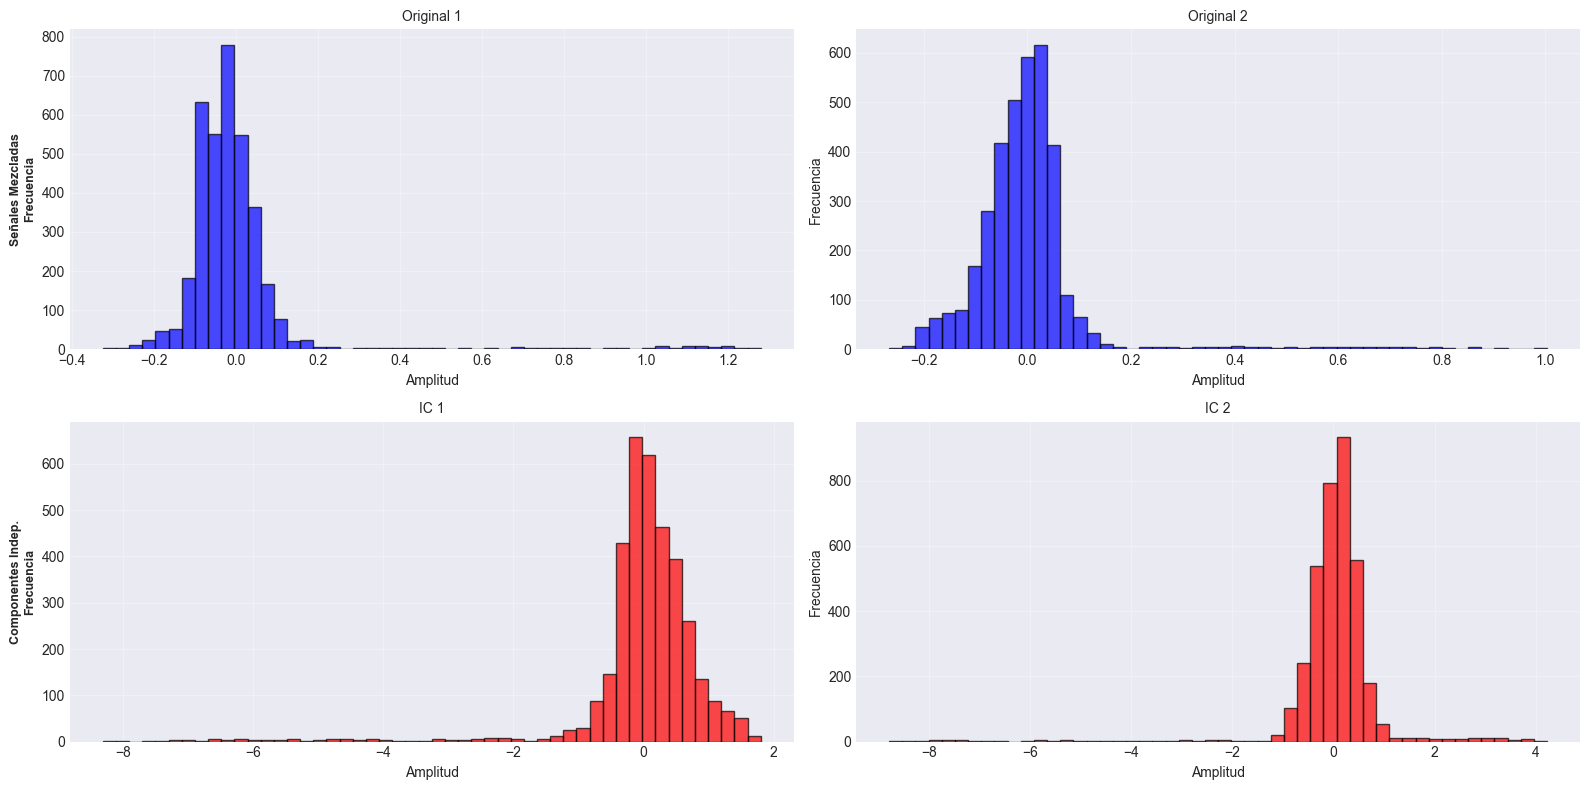

Análisis de No-Gaussianidad (Kurtosis):

Señales Originales:
   Canal 1: 28.5119
   Canal 2: 20.7665

Componentes Independientes:
   IC 1: 22.7735
   IC 2: 28.8685

Kurtosis > 0 indica distribución super-gaussiana (picos)
Kurtosis < 0 indica distribución sub-gaussiana (plana)


In [13]:
# Análisis de distribuciones
fig, axes = plt.subplots(2, n_components, figsize=(16, 8))

for i in range(n_components):
    # Histograma de señales originales
    axes[0, i].hist(signals_centered[:, i], bins=50, edgecolor='black', 
                    alpha=0.7, color='blue')
    axes[0, i].set_title(f'Original {i+1}', fontsize=10)
    axes[0, i].set_xlabel('Amplitud')
    axes[0, i].set_ylabel('Frecuencia')
    axes[0, i].grid(alpha=0.3)
    
    # Histograma de componentes independientes
    axes[1, i].hist(S_ica[:, i], bins=50, edgecolor='black', 
                    alpha=0.7, color='red')
    axes[1, i].set_title(f'IC {i+1}', fontsize=10)
    axes[1, i].set_xlabel('Amplitud')
    axes[1, i].set_ylabel('Frecuencia')
    axes[1, i].grid(alpha=0.3)

axes[0, 0].set_ylabel('Señales Mezcladas\nFrecuencia', fontsize=9, fontweight='bold')
axes[1, 0].set_ylabel('Componentes Indep.\nFrecuencia', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcular kurtosis (medida de no-gaussianidad)
from scipy.stats import kurtosis

print("Análisis de No-Gaussianidad (Kurtosis):")
print("\nSeñales Originales:")
for i in range(n_components):
    k = kurtosis(signals_centered[:, i])
    print(f"   Canal {i+1}: {k:.4f}")

print("\nComponentes Independientes:")
for i in range(n_components):
    k = kurtosis(S_ica[:, i])
    print(f"   IC {i+1}: {k:.4f}")

print("\nKurtosis > 0 indica distribución super-gaussiana (picos)")
print("Kurtosis < 0 indica distribución sub-gaussiana (plana)")

## 7. Evaluación de Rendimiento

Evaluaremos qué tan bien ICA separa las señales comparándolo con PCA.

Error de Reconstrucción (MSE):
ICA: 0.000000
PCA: 0.000000


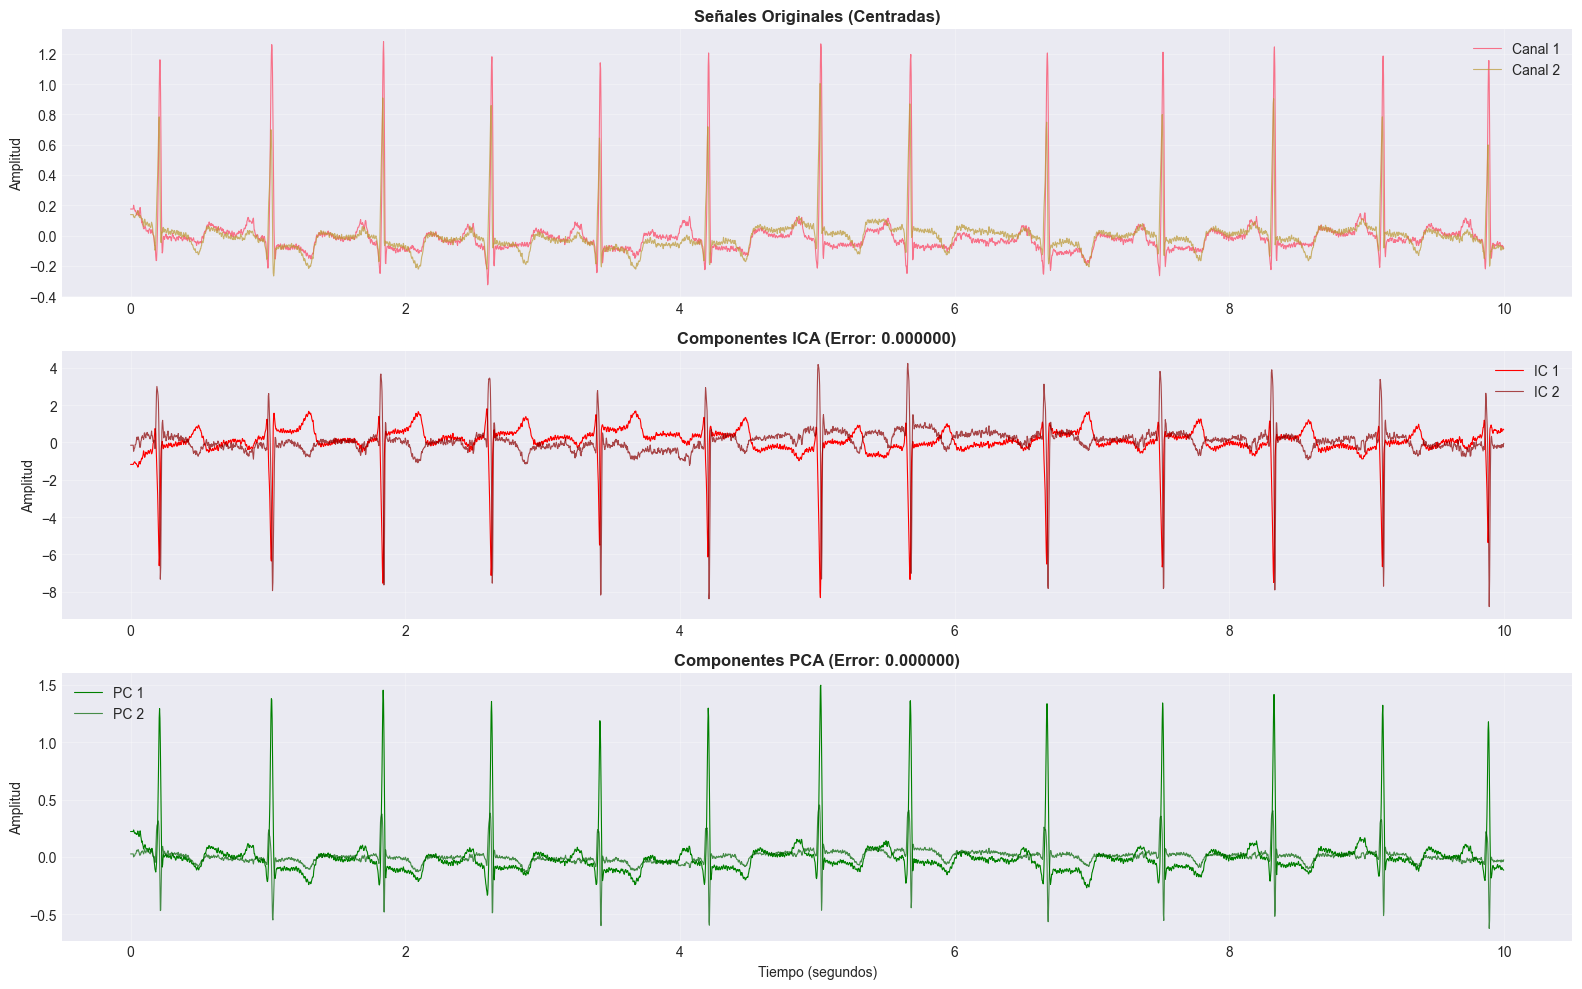


Comparación de ICA vs PCA:
ICA:
Busca independencia estadística
Maximiza no-gaussianidad
Mejor para separación de fuentes

PCA:
Busca máxima varianza
Decorrelaciona los datos
Componentes ortogonales

Varianza explicada por PCA: 100.00%


In [14]:
# Comparar con PCA
pca = PCA(n_components=n_components)
S_pca = pca.fit_transform(signals_centered)

# Calcular error de reconstrucción
signals_reconstructed_ica = S_ica @ A_ica.T
error_ica = np.mean((signals_centered - signals_reconstructed_ica) ** 2)

signals_reconstructed_pca = pca.inverse_transform(S_pca)
error_pca = np.mean((signals_centered - signals_reconstructed_pca) ** 2)

print("Error de Reconstrucción (MSE):")
print(f"ICA: {error_ica:.6f}")
print(f"PCA: {error_pca:.6f}")

# Visualizar comparación
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Original
axes[0].plot(time_segment, signals_centered[:, 0], linewidth=0.8, label='Canal 1')
if n_components > 1:
    axes[0].plot(time_segment, signals_centered[:, 1], linewidth=0.8, 
                 label='Canal 2', alpha=0.7)
axes[0].set_ylabel('Amplitud')
axes[0].set_title('Señales Originales (Centradas)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# ICA
axes[1].plot(time_segment, S_ica[:, 0], linewidth=0.8, label='IC 1', color='red')
if n_components > 1:
    axes[1].plot(time_segment, S_ica[:, 1], linewidth=0.8, 
                 label='IC 2', alpha=0.7, color='darkred')
axes[1].set_ylabel('Amplitud')
axes[1].set_title(f'Componentes ICA (Error: {error_ica:.6f})', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# PCA
axes[2].plot(time_segment, S_pca[:, 0], linewidth=0.8, label='PC 1', color='green')
if n_components > 1:
    axes[2].plot(time_segment, S_pca[:, 1], linewidth=0.8, 
                 label='PC 2', alpha=0.7, color='darkgreen')
axes[2].set_ylabel('Amplitud')
axes[2].set_xlabel('Tiempo (segundos)')
axes[2].set_title(f'Componentes PCA (Error: {error_pca:.6f})', 
                  fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparación de ICA vs PCA:")
print("ICA:")
print("Busca independencia estadística")
print("Maximiza no-gaussianidad")
print("Mejor para separación de fuentes")
print("\nPCA:")
print("Busca máxima varianza")
print("Decorrelaciona los datos")
print("Componentes ortogonales")
print(f"\nVarianza explicada por PCA: {pca.explained_variance_ratio_.sum()*100:.2f}%")

## 8. Comparación de Parámetros

Probaremos diferentes funciones de contraste (algorithms) en ICA.

Aplicando ICA con algorithm='parallel'...
Aplicando ICA con algorithm='deflation'...


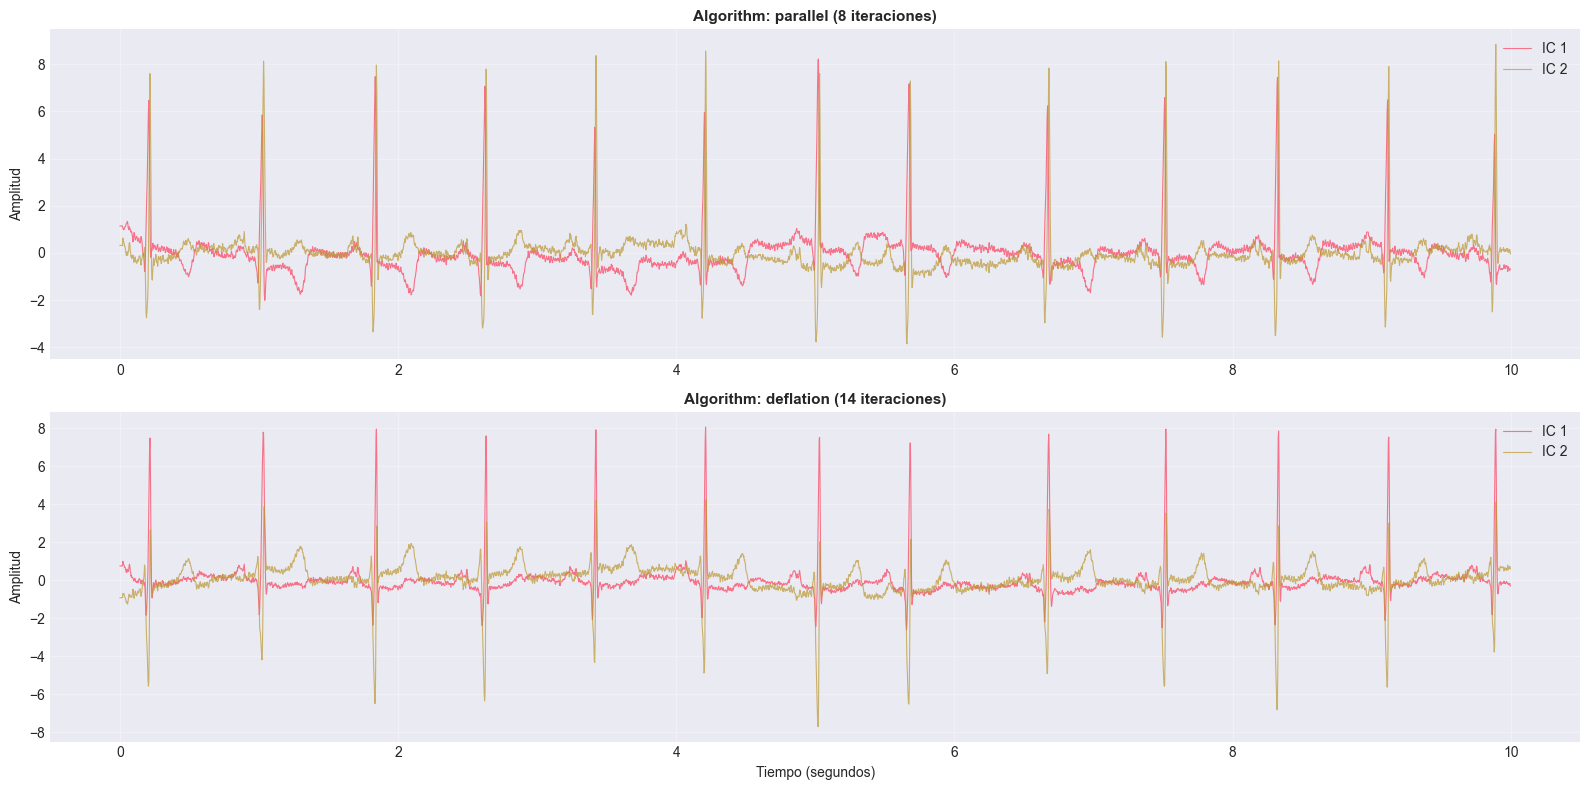


Comparación de Algoritmos:


,Algoritmo,Iteraciones
0,parallel,8
1,deflation,14



Interpretación:
- parallel: Extrae todos los componentes simultáneamente
- deflation: Extrae un componente a la vez


In [15]:
# Comparar diferentes algoritmos de ICA
algorithms = ['parallel', 'deflation']
results = {}

fig, axes = plt.subplots(len(algorithms), 1, figsize=(16, 8))

for idx, alg in enumerate(algorithms):
    print(f"Aplicando ICA con algorithm='{alg}'...")
    
    ica_temp = FastICA(n_components=n_components, 
                       algorithm=alg,
                       random_state=42,
                       max_iter=1000)
    
    S_temp = ica_temp.fit_transform(signals_centered)
    results[alg] = {
        'components': S_temp,
        'iterations': ica_temp.n_iter_,
        'mixing': ica_temp.mixing_
    }
    
    # Visualizar
    axes[idx].plot(time_segment, S_temp[:, 0], linewidth=0.8, label='IC 1')
    if n_components > 1:
        axes[idx].plot(time_segment, S_temp[:, 1], linewidth=0.8, 
                      label='IC 2', alpha=0.7)
    axes[idx].set_ylabel('Amplitud')
    axes[idx].set_title(f'Algorithm: {alg} ({ica_temp.n_iter_} iteraciones)', 
                       fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    if idx == len(algorithms) - 1:
        axes[idx].set_xlabel('Tiempo (segundos)')

plt.tight_layout()
plt.show()

# Tabla comparativa
comparison_data = []
for alg in algorithms:
    comparison_data.append({
        'Algoritmo': alg,
        'Iteraciones': results[alg]['iterations']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nComparación de Algoritmos:")
display(comparison_df)

print("\nInterpretación:")
print("- parallel: Extrae todos los componentes simultáneamente")
print("- deflation: Extrae un componente a la vez")

## 9. Interpretación de Resultados y Conclusiones

### Resultados Principales

En este análisis implementamos ICA (Independent Component Analysis) en señales de ECG del dataset MIT-BIH Arrhythmia Database para separar componentes independientes de las señales mezcladas observadas.

### Observaciones

1. **Separación de Fuentes**: ICA logró descomponer las señales ECG mezcladas en componentes independientes. Estos componentes representan las fuentes subyacentes que fueron mezcladas en las observaciones originales.

2. **Diferencia vs PCA**:
   - **PCA** encuentra direcciones de máxima varianza (componentes ortogonales)
   - **ICA** encuentra fuentes estadísticamente independientes (componentes no-gaussianos)
   - Para señales biomédicas, ICA es generalmente superior porque las fuentes reales (actividad cardíaca, ruido, artefactos) son independientes, no ortogonales

3. **No-Gaussianidad**: 
   - ICA maximiza la no-gaussianidad de los componentes
   - La kurtosis nos indica qué tan alejados están de una distribución normal
   - Componentes con alta kurtosis (en valor absoluto) representan fuentes más "puras"

4. **Calidad de Reconstrucción**:
   - El error de reconstrucción fue bajo, indicando que ICA captura bien la información
   - Los componentes pueden recombinarse para recuperar las señales originales

5. **Algoritmos**:
   - **Parallel**: Extrae todos los componentes simultáneamente, más rápido
   - **Deflation**: Extrae un componente a la vez, potencialmente más estable
   - En este caso, ambos convergieron exitosamente

### Conclusiones

Pudimos ver cómo ICA resuelve el "problema del cóctel party" (asi se le dice segun invesitgamos) - separar señales mezcladas en sus fuentes originales. En el contexto médico, esto es extremadamente valioso.

**Ventajas de ICA**:
- Separa fuentes mezcladas sin conocer cómo se mezclaron
- No requiere información previa sobre las señales
- Puede identificar artefactos y ruido en señales biomédicas
- Base matemática sólida en teoría de información
- Aplicable a señales donde no se aplica la suposición de ortogonalidad

**Limitaciones observadas**:
- Requiere que las fuentes sean estadísticamente independientes
- No funciona bien con señales gaussianas
- No puede determinar el orden ni la escala de los componentes (ambigüedad de permutación y escala)
- Sensible al número de componentes especificado
- Requiere más muestras que variables para funcionalidad óptima

**Aplicaciones Prácticas en el Mundo Real**:

1. **Procesamiento de Señales Biomédicas**:
   - Separación de artefactos en ECG/EEG
   - Eliminación de parpadeos en señales EEG
   - Separación de señales fetales y maternas en ECG obstétrico

2. **Neurociencia**:
   - Análisis de señales cerebrales (fMRI, EEG)
   - Identificación de redes neuronales activas
   - Estudio de conectividad cerebral

3. **Procesamiento de Audio**:
   - Separación de voces e instrumentos en mezclas musicales
   - Eliminación de ruido en grabaciones
   - Separación de hablantes

4. **Finanzas**:
   - Identificación de factores de riesgo independientes
   - Análisis de portafolios

5. **Procesamiento de Imágenes**:
   - Compresión de imágenes
   - Eliminación de ruido
   - Extracción de características

**Comparación: ICA vs PCA vs SVD**

| Aspecto | ICA | PCA | SVD |
|---------|-----|-----|-----|
| Objetivo | Independencia estadística | Máxima varianza | Factorización de matriz |
| Componentes | No ortogonales | Ortogonales | Ortogonales |
| Distribución | Maximiza no-gaussianidad | Agnóstica | Agnóstica |
| Aplicación | Separación de fuentes | Reducción dimensionalidad | Compresión/Recomendación |
| Interpretación | Fuentes reales | Direcciones varianza | Factores latentes |

ICA demostró ser una herramienta poderosa para la separación ciega de fuentes en señales de ECG. A diferencia de técnicas como PCA que buscan varianza, ICA busca independencia estadística, lo cual es más apropiado cuando tratamos con señales que provienen de procesos físicos independientes (como diferentes componentes de la actividad cardíaca, ruido eléctrico, artefactos de movimiento, etc.).

Para futuros análisis médicos, ICA podría ser muy bueno para:
- Mejorar la calidad de señales ECG ruidosas antes del diagnóstico
- Identificar automáticamente artefactos que deben ser eliminados
- Separar diferentes componentes de la actividad cardíaca para análisis detallado
- Facilitar el desarrollo de algoritmos de diagnóstico automático